In [1]:
import tensorflow as tf,os,math,numpy as np
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from tensorflow.keras.preprocessing.image import \
load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing import \
image_dataset_from_directory
from IPython.display import display
import pylab as pl,PIL
from mpl_toolkits.axes_grid1.inset_locator import \
zoomed_inset_axes,mark_inset

In [2]:
dataset_url='http://www.eecs.berkeley.edu/Research/'+\
            'Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
data_dir=tf.keras.utils.get_file(
    origin=dataset_url,fname='BSR',untar=True)
root_dir=os.path.join(data_dir,'BSDS500/data')
data_path=os.path.join(root_dir,'images')
test_path=os.path.join(data_path,'test')
test_paths=sorted(
    [os.path.join(test_path,fname) 
    for fname in os.listdir(test_path)
    if fname.endswith('.jpg')])
test_paths[:3]

['/root/.keras/datasets/BSR/BSDS500/data/images/test/100007.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100039.jpg',
 '/root/.keras/datasets/BSR/BSDS500/data/images/test/100099.jpg']

In [3]:
def scale01(img): return img/255
def process_input(input_rgb,img_size):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return tf.image.resize(y,[img_size,img_size],method='area')
def process_target(input_rgb):
    input_yuv=tf.image.rgb_to_yuv(input_rgb)
    last_dimension_axis=len(input_yuv.shape)-1
    y,u,v=tf.split(input_yuv,3,axis=last_dimension_axis)
    return y  

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


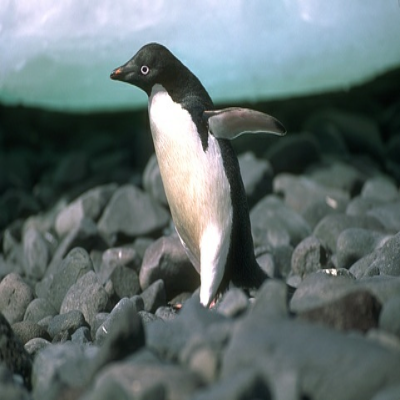

In [4]:
[crop_size,upscale_factor]=[400,4]
input_size=crop_size//upscale_factor
batch_size=8
train_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='training',
    seed=123,label_mode=None,)
valid_ds=image_dataset_from_directory(
    root_dir,batch_size=batch_size,
    image_size=(crop_size,crop_size),
    validation_split=.2,subset='validation',
    seed=123,label_mode=None,)
train_ds=train_ds.map(scale01)
valid_ds=valid_ds.map(scale01)
for batch in train_ds.take(1):
    for img in batch: display(array_to_img(img)); break

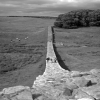

==> ==> ==> ==> ==> ==> ==> ==> ==> ==> 


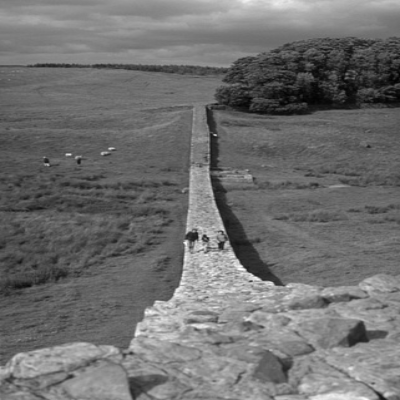

In [5]:
train_ds=train_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
train_ds=train_ds.prefetch(buffer_size=16)
valid_ds=valid_ds.map(
    lambda x:(process_input(x,input_size),process_target(x)))
valid_ds=valid_ds.prefetch(buffer_size=16)
for batch in valid_ds.take(1):
    for img in batch[0]: display(array_to_img(img)); break
    print(10*'==> ')
    for img in batch[1]: display(array_to_img(img)); break

In [6]:
def model(upscale_factor=upscale_factor,channels=1):
    conv_args={'activation':'relu',
               'kernel_initializer':'Orthogonal',
               'padding':'same',}
    inputs=tf.keras.Input(shape=(None,None,channels))
    x=tkl.Conv2D(128,5,**conv_args)(inputs)
    x=tkl.Conv2D(64,5,**conv_args)(x)
    x=tkl.Conv2D(32,3,**conv_args)(x)
    x=tkl.Conv2D(channels*(upscale_factor**2),3,**conv_args)(x)
    outputs=tf.nn.depth_to_space(x,upscale_factor)
    return tf.keras.Model(inputs,outputs)

In [7]:
def display_results(img,prefix,title):
    img_array=img_to_array(img)
    img_array=img_array.astype('float32')/255
    fig,ax=pl.subplots()
    im=ax.imshow(img_array[::-1],origin='lower')
    pl.title(title)
    axins=zoomed_inset_axes(ax,2,loc=5)
    axins.imshow(img_array[::-1],origin='lower')
    x1,x2,y1,y2=200,300,100,200
    axins.set_xlim(x1,x2); axins.set_ylim(y1,y2)
    pl.yticks(visible=False); pl.xticks(visible=False)
    mark_inset(ax,axins,loc1=1,loc2=3,fc='none',ec='magenta')
    pl.savefig(str(prefix)+'-'+title+'.png')
    pl.show()
def low_resolution_img(img,upscale_factor):
    dimensions=(img.size[0]//upscale_factor,
                img.size[1]//upscale_factor)
    return img.resize(dimensions,PIL.Image.BICUBIC,)
def upscale_img(model,img):
    ycbcr=img.convert('YCbCr')
    y,cb,cr=ycbcr.split()
    y=img_to_array(y).astype('float32')/255
    input_img=np.expand_dims(y,axis=0)
    out=model.predict(input_img)
    out_img_y=out[0]*255.
    out_img_y=out_img_y.clip(0,255)
    out_img_y=out_img_y.reshape(
        (np.shape(out_img_y)[0],np.shape(out_img_y)[1]))
    out_img_y=PIL.Image.fromarray(np.uint8(out_img_y),mode='L')
    out_img_cb=cb.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img_cr=cr.resize(out_img_y.size,PIL.Image.BICUBIC)
    out_img=PIL.Image.merge(
        'YCbCr',(out_img_y,out_img_cb,out_img_cr))
    return out_img.convert('RGB')

In [8]:
class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback,self).__init__()
        self.test_img=low_resolution_img(
            load_img(test_paths[0]),upscale_factor)
    def on_epoch_begin(self,epoch,logs=None):
        self.psnr=[]
    def on_epoch_end(self,epoch,logs=None):
        print('mean PSNR for epoch: %.2f'%(np.mean(self.psnr)))
        if epoch%25==0:
            prediction=upscale_img(self.model,self.test_img)
            display_results(
                prediction,'epoch-'+str(epoch),'prediction')
    def on_test_batch_end(self,batch,logs=None):
        self.psnr.append(10*math.log10(1/logs['loss']))

In [9]:
early_stopping=tkc.EarlyStopping(monitor='loss',patience=10)
checkpoint_path='/tmp/checkpoint'
checkpoint=tkc.ModelCheckpoint(
    filepath=checkpoint_path,save_weights_only=True,
    monitor='loss',mode='min',save_best_only=True,verbose=2)

In [10]:
model=model(upscale_factor=upscale_factor,channels=1)
model.summary()
callbacks=[ESPCNCallback(),early_stopping,checkpoint]
loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=.001)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 128)   3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    4624      
_________________________________________________________________
tf.nn.depth_to_space (TFOpLa (None, None, None, 1)     0         
Total params: 231,280
Trainable params: 231,280
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
50/50 - 4s - loss: 0.0472 - val_loss: 0.0131
mean PSNR for epoch: 19.09


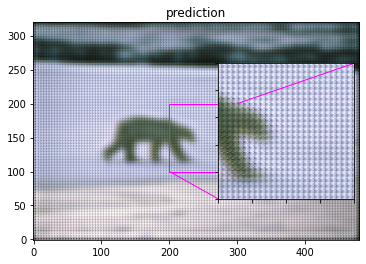


Epoch 00001: loss improved from inf to 0.04722, saving model to /tmp/checkpoint
Epoch 2/100
50/50 - 3s - loss: 0.0068 - val_loss: 0.0055
mean PSNR for epoch: 22.67

Epoch 00002: loss improved from 0.04722 to 0.00681, saving model to /tmp/checkpoint
Epoch 3/100
50/50 - 3s - loss: 0.0041 - val_loss: 0.0040
mean PSNR for epoch: 23.94

Epoch 00003: loss improved from 0.00681 to 0.00406, saving model to /tmp/checkpoint
Epoch 4/100
50/50 - 3s - loss: 0.0034 - val_loss: 0.0035
mean PSNR for epoch: 24.63

Epoch 00004: loss improved from 0.00406 to 0.00339, saving model to /tmp/checkpoint
Epoch 5/100
50/50 - 3s - loss: 0.0031 - val_loss: 0.0033
mean PSNR for epoch: 24.71

Epoch 00005: loss improved from 0.00339 to 0.00311, saving model to /tmp/checkpoint
Epoch 6/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0032
mean PSNR for epoch: 24.91

Epoch 00006: loss improved from 0.00311 to 0.00293, saving model to /tmp/checkpoint
Epoch 7/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0031
mean PSNR for epo

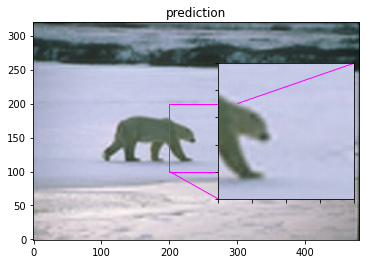


Epoch 00026: loss did not improve from 0.00255
Epoch 27/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0034
mean PSNR for epoch: 24.62

Epoch 00027: loss did not improve from 0.00255
Epoch 28/100
50/50 - 3s - loss: 0.0029 - val_loss: 0.0031
mean PSNR for epoch: 24.99

Epoch 00028: loss did not improve from 0.00255
Epoch 29/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0029
mean PSNR for epoch: 25.16

Epoch 00029: loss did not improve from 0.00255
Epoch 30/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.43

Epoch 00030: loss improved from 0.00255 to 0.00253, saving model to /tmp/checkpoint
Epoch 31/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.63

Epoch 00031: loss improved from 0.00253 to 0.00252, saving model to /tmp/checkpoint
Epoch 32/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0028
mean PSNR for epoch: 25.59

Epoch 00032: loss improved from 0.00252 to 0.00251, saving model to /tmp/checkpoint
Epoch 33/100
50/50 - 3s - loss: 0.0025 - va

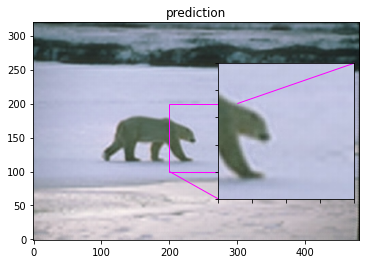


Epoch 00051: loss did not improve from 0.00245
Epoch 52/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.52

Epoch 00052: loss improved from 0.00245 to 0.00244, saving model to /tmp/checkpoint
Epoch 53/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0029
mean PSNR for epoch: 25.43

Epoch 00053: loss did not improve from 0.00244
Epoch 54/100
50/50 - 3s - loss: 0.0027 - val_loss: 0.0047
mean PSNR for epoch: 23.33

Epoch 00054: loss did not improve from 0.00244
Epoch 55/100
50/50 - 3s - loss: 0.0031 - val_loss: 0.0028
mean PSNR for epoch: 25.70

Epoch 00055: loss did not improve from 0.00244
Epoch 56/100
50/50 - 3s - loss: 0.0025 - val_loss: 0.0027
mean PSNR for epoch: 25.67

Epoch 00056: loss did not improve from 0.00244
Epoch 57/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.62

Epoch 00057: loss improved from 0.00244 to 0.00243, saving model to /tmp/checkpoint
Epoch 58/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 2

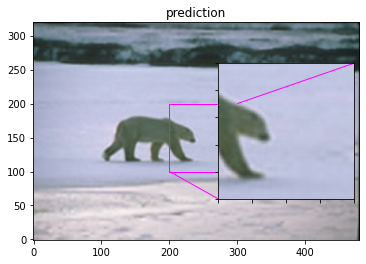


Epoch 00076: loss improved from 0.00240 to 0.00239, saving model to /tmp/checkpoint
Epoch 77/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.56

Epoch 00077: loss improved from 0.00239 to 0.00239, saving model to /tmp/checkpoint
Epoch 78/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.70

Epoch 00078: loss did not improve from 0.00239
Epoch 79/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.34

Epoch 00079: loss did not improve from 0.00239
Epoch 80/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.61

Epoch 00080: loss improved from 0.00239 to 0.00239, saving model to /tmp/checkpoint
Epoch 81/100
50/50 - 3s - loss: 0.0024 - val_loss: 0.0027
mean PSNR for epoch: 25.90

Epoch 00081: loss improved from 0.00239 to 0.00238, saving model to /tmp/checkpoint
Epoch 82/100
50/50 - 3s - loss: 0.0026 - val_loss: 0.0042
mean PSNR for epoch: 23.94

Epoch 00082: loss did not improve from 0.00238
Epoch 

In [11]:
epochs=100
model.compile(optimizer=optimizer,loss=loss_fn,)
model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,
    validation_data=valid_ds,verbose=2)
model.load_weights(checkpoint_path)

PSNR of low resolution image and high resolution image is 21.9522
PSNR of predict and high resolution is 22.5378


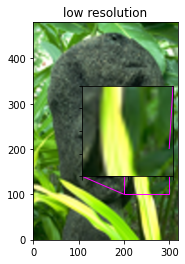

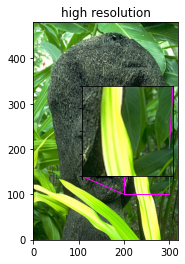

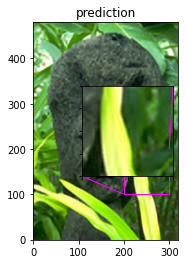

PSNR of low resolution image and high resolution image is 20.5894
PSNR of predict and high resolution is 20.9406


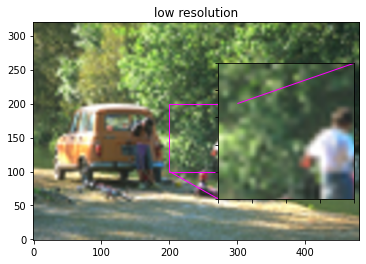

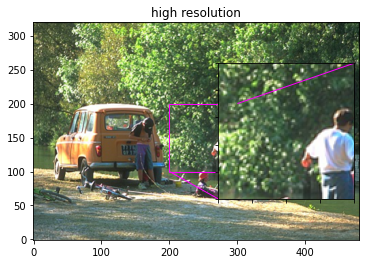

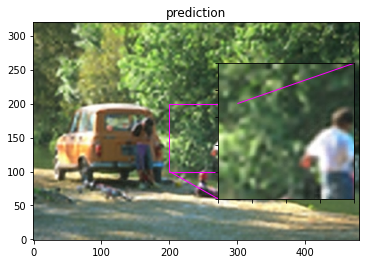

PSNR of low resolution image and high resolution image is 22.6938
PSNR of predict and high resolution is 23.3666


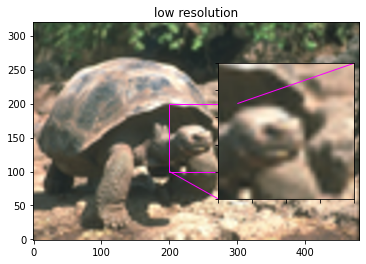

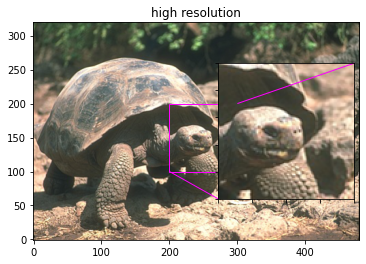

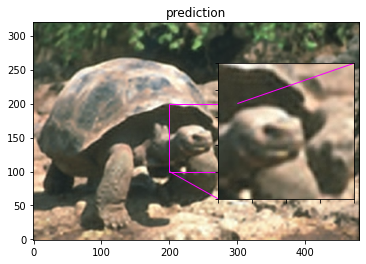

PSNR of low resolution image and high resolution image is 32.0279
PSNR of predict and high resolution is 32.8635


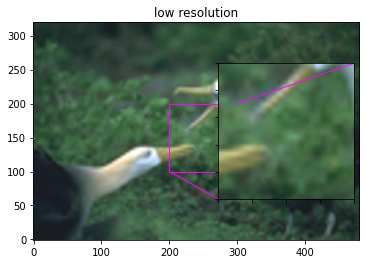

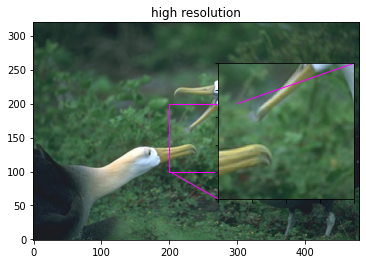

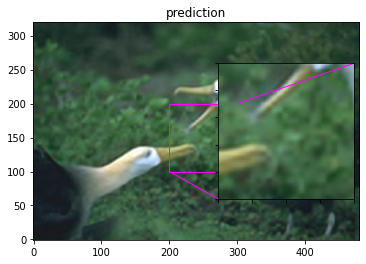

PSNR of low resolution image and high resolution image is 25.4892
PSNR of predict and high resolution is 26.1291


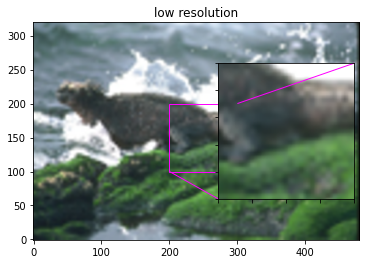

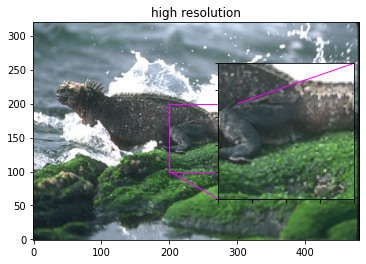

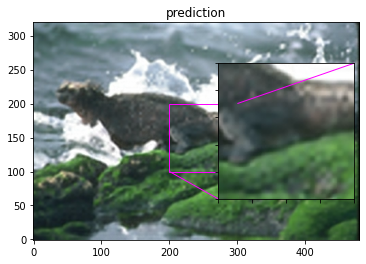

avg. PSNR of images with low resolution is 12.2753
avg. PSNR of reconstructions is 12.5838


In [13]:
total_bicubic_psnr=0.; total_test_psnr=0.
for index,test_path in enumerate(test_paths[5:10]):
    img=load_img(test_path)
    lowres_input=low_resolution_img(img,upscale_factor)
    w=lowres_input.size[0]*upscale_factor
    h=lowres_input.size[1]*upscale_factor
    highres_img=img.resize((w,h))
    predict_img=upscale_img(model,lowres_input)
    lowres_img=lowres_input.resize((w,h))
    lowres_img_arr=img_to_array(lowres_img)
    highres_img_arr=img_to_array(highres_img)
    predict_img_arr=img_to_array(predict_img)
    bicubic_psnr=tf.image.psnr(
        lowres_img_arr,highres_img_arr,max_val=255)
    test_psnr=tf.image.psnr(
        predict_img_arr,highres_img_arr,max_val=255)
    total_bicubic_psnr+=bicubic_psnr
    total_test_psnr+=test_psnr
    print('PSNR of low resolution image '+\
          'and high resolution image is %.4f'%bicubic_psnr)
    print('PSNR of predict and high resolution is %.4f'%test_psnr)
    display_results(lowres_img,index,'low resolution')
    display_results(highres_img,index,'high resolution')
    display_results(predict_img,index,'prediction')
print('avg. PSNR of images with low resolution is %.4f'\
      %(total_bicubic_psnr/10))
print('avg. PSNR of reconstructions is %.4f'\
      %(total_test_psnr/10))